# Plot figures

-  **_Reproduce small sample versions_** of kernel thinning experiment figures from the paper https://arxiv.org/pdf/2105.05842.pdf
    - The paper shows figures for coreset size sqrt(n) = 2^2 to 2^7
    - This notebook plots the same figures for coreset size sqrt(n) = 2^1 to 2^4
    - For reproducing identical figures, the slurm jobs need to be run with m_max set to 7; and then rerunning this notebook with ms = range(8) in the first cell in Section 1
- Plot MMD_k(P, S), and MMD_k(Sin, S) for Gaussian(sigma) kernel for kernel thinning with
    - P = N(0, I_d) in d = 2, 3, 4 dimensions; sigma = 1
    - Mixture of Gaussian P (MoG) in d=2, for M = 4, 6, 8 mixtures; sigma = 1 (see the function compute_mog_params in util_sample, or the paper for details)
    - 8 MCMC data settings; sigma = median_distance in mcmc data (d = 4)
- Show scatter plot of iid and KT coresets for MoG settings

## 0.1 import libraries, and fix plot setting

In [2]:
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
from scipy.spatial.distance import pdist

import pathlib
import os
import os.path
import pickle as pkl

# Fitting linear models
import statsmodels.api as sm
from scipy.stats import multivariate_normal

# plottibg libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab
import seaborn as sns
plt.style.use('seaborn-white')

# utils for generating samples, evaluating kernels, and mmds
from util_sample import sample, compute_mcmc_params_p, compute_diag_mog_params, sample_string
from util_k_mmd import get_combined_mmd_filename

# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
# https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fix_plot_settings = True
if fix_plot_settings:
    plt.rc('font', family='serif')
    plt.rc('text', usetex=False)
    label_size = 20
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    mpl.rcParams['axes.labelsize'] = label_size
    mpl.rcParams['axes.titlesize'] = label_size
    mpl.rcParams['figure.titlesize'] = label_size
    mpl.rcParams['lines.markersize'] = label_size
    mpl.rcParams['grid.linewidth'] = 2.5
    mpl.rcParams['legend.fontsize'] = label_size
    pylab.rcParams['xtick.major.pad']=5
    pylab.rcParams['ytick.major.pad']=5

    lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
    mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
    ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
    colors = ['#e41a1c', '#0000cd', '#4daf4a',  'black' , 'magenta']
else:
    pass

## 0.2 Define helper functions for loading / plotting mmds; and loading input / coresets

In [34]:
def load_mmds(ms, params_p, params_k_split, params_k_swap, rep_ids, delta=0.5, 
                      sample_seed=1234567, thin_seed=9876543, results_dir="results_new/combined"):
    """
    Return dictionary of mmd results
    
    ms: range of thinning rounds
    params_p: Dictionary of distribution parameters recognized by sample()
    params_k_split: Dictionary of kernel parameters recognized by kernel() # used for kt split
    params_k_swap: Dictionary of kernel parameters recognized by kernel() # used for kt swap; and computing mmd
    rep_ids: Which replication numbers of experiment to run; the replication
        number determines the seeds set for reproducibility
    delta: If c is None, delta/(4^m) is the failure probability for
        adaptive threshold sequence
    sample_seed: (Optional) starting seed for sample generation 
    thin_seed: (Optional) starting seed for thinning experiments
    results_dir: Folder where the results are loaded from
    """
   
    mmds_dict = dict()
    mmds_dict["P"] = dict()
    mmds_dict["Sin"] = dict()
    filename =  get_combined_mmd_filename(f"mc", ms, params_p, params_k_split, params_k_swap, rep_ids, delta)
    key = 'iid' if params_p["name"] in ["gauss", "diag_mog"] else 'standard'
    with open(filename, 'rb') as file:
        mmds_dict["P"][key] = pkl.load(file)

    filename = get_combined_mmd_filename(f"kt", ms, params_p, params_k_split, params_k_swap, rep_ids, delta)
    with open(filename, 'rb') as file:
        mmds_dict["P"]["KT"] = pkl.load(file)
        
    filename =  get_combined_mmd_filename(f"mc-sin", ms, params_p, params_k_split, params_k_swap, rep_ids, delta)
    key = 'iid' if params_p["name"] in ["gauss", "diag_mog"] else 'standard'
    with open(filename, 'rb') as file:
        mmds_dict["Sin"][key] = pkl.load(file)

    filename = get_combined_mmd_filename(f"kt-sin", ms, params_p, params_k_split, params_k_swap, rep_ids, delta)
    with open(filename, 'rb') as file:
        mmds_dict["Sin"]["KT"] = pkl.load(file)

    return(mmds_dict)

def load_input_and_coreset(m, params_p, params_k_split, params_k_swap, rep_id, delta=0.5, 
                      sample_seed=1234567, thin_seed=9876543, results_dir="results_new", verbose=False):
    """Return exisiting coresets by loading from disk, and the associated MC points used for finding the coresets
    if return_ktplus = True, return the KTplus coresets.
    
    Args:
      m: Number of halving rounds (number of sample points n = 2^{2m})
      params_p: Dictionary of distribution parameters recognized by sample()
      params_k_split: Dictionary of kernel parameters recognized by kernel() # used for kt split
      params_k_swap: Dictionary of kernel parameters recognized by kernel() # used for kt swap; and computing mmd
      rep_id: A single rep id for which coreset to be returned
      delta: If c is None, delta/(4^m) is the failure probability for
        adaptive threshold sequence
      sample_seed: (Optional) random seed is set to sample_seed + rep
        prior to generating input sample for replication rep
      thin_seed: (Optional) random seed is set to thin_seed + rep
        prior to running thinning for replication rep
      results_dir: (Optional) Directory in which results is to be loaded from
      verbose: (Optional) If True, print intermediate updates
    """
    
    d = params_p["d"]
    assert(d == params_k_split["d"])
    assert(d == params_k_swap["d"])
    sample_str = sample_string(params_p, sample_seed)
    split_kernel_str = "{}_var{:.3f}_seed{}".format(params_k_split["name"], params_k_split["var"], thin_seed)
    swap_kernel_str =  "{}_var{:.3f}".format(params_k_swap["name"], params_k_swap["var"])
    thresh_str = f"delta{delta}"
    file_template = os.path.join(results_dir, f"kt-coresets-{sample_str}-split{split_kernel_str}-swap{swap_kernel_str}-d{d}-m{m}-{thresh_str}-rep{{}}.pkl")
    
    filename = file_template.format(rep_id)
    n = int(2**(2*m))
    ncoreset = int(2**m)
    X = sample(n, params_p, seed=sample_seed+rep_id)
    if os.path.exists(filename):
        with open(filename, 'rb') as file:
            if verbose:
                print(f"Loading KT coreset indices from {filename}")
            coresets = pkl.load(file)
    else:
        raise ValueError(f"File {filename} not found")

    if verbose:
        print(f"Returning all {n} input MC points and {ncoreset} KT points")
    return(X, X[coresets[:ncoreset]])
    
def plot_mmd_dict(axes, ms, mmds_dict, size_factor=1., error_bar = True, error_shade = False, skip_ns=int(0),
                  legend_size=mpl.rcParams['legend.fontsize']):
    '''
        Plot mmd rates
        axes: axes objet for a matplotlib figure
        ms: array of integers denoting the logarithmic range of coreset size (m=log_2 coreset size)
        mmds_dict: Dictionary of mmd rates; each entry should have size Rep x len(ms)
        size_factor: Float, scaling of marker size
        error_bar: Boolean, When true error bars across Reps are plotted for each key in mmds_dict
        error_shade: Boolean, When true shaded error regions are be plotted for each key in mmds_dict
        skip_ns: Integer, starting index for the plot (how many entries to skip in ms, and mmds_dict keys)
        legend_size: Size of the legend in the plot
        
    '''
    ns = np.power(2, ms[skip_ns:], dtype=int)
    X = sm.add_constant(np.log(ns**2))
    ls = []
    labs = []
    for i, (label, mmd) in enumerate(mmds_dict.items()):
        y = np.nanmedian(mmd, axis=1)
        yerr = np.nanstd(mmd, axis=1) / np.sqrt((~np.isnan(mmd)).sum(axis=1))
        y = y[skip_ns:]
        yerr = yerr[skip_ns:]
        model = sm.OLS(np.log(y), X).fit()
        
        if not(error_bar) and not(error_shade):
            l1, = axes.plot(ns, y, marker=mss[i], linestyle='None', 
                           color=colors[i], alpha=1., markersize=size_factor*ms_size[i])
        
        else:
            if error_bar:
                l1 = axes.errorbar(ns, y, marker=mss[i], yerr=np.array([np.zeros_like(yerr), yerr]), linestyle='None', 
                            color=colors[i], alpha=1., markersize=size_factor*ms_size[i], elinewidth=5)
            if error_shade:
                axes.fill_between(ns, y-yerr, y+yerr, alpha=0.2, color=colors[i])
                
        l2, = axes.plot(ns, np.exp(model.predict(X)),
                                   linestyle=lss[i],
                                   linewidth=4, color=colors[i], alpha=.5)
        
        labs.append(label.replace("_", " ") + r": n$^{%.2f}$"%(model.params[1]))
        ls.append((l1, l2))
        
        axes.legend(ls, labs, loc="lower left", handletextpad=0.0, fontsize=legend_size)
        axes.set_xscale('log', basex=2)
        axes.set_yscale('log', basey=2)
        axes.spines['top'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        axes.spines['right'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        axes.grid(True, alpha=0.4)
    return

# 1. Load the mmd results

In [5]:
mcmc_file_names = [ 'Goodwin_RW', 'Goodwin_ADA-RW',
                   'Goodwin_MALA', 'Goodwin_PRECOND-MALA',  
                   'Lotka_RW', 'Lotka_ADA-RW',  'Lotka_MALA','Lotka_PRECOND-MALA']
var = 1.
rep_ids = range(100)
ms = range(4+1)
ds = [2, 3, 4]
Ms = [4, 6, 8]
mc_mmds = dict()
mcmc_mmds = dict()

In [24]:
for d in ds:
    var = 1.
    params_k_swap = {"name": "gauss", "var": var, "d": int(d)}
    params_k_split = {"name": "gauss_rt", "var": var/2., "d": int(d)}
    params_p = {"name": "gauss", "var": var, "d": int(d), "saved_samples": False}
    print(f"loading results for Gauss kernel and Gauss P in d={d}")
    mc_mmds[f"gauss-{d}"] = load_mmds(ms, params_p, params_k_split, params_k_swap, rep_ids)
    if d == 2:
        for M in Ms:
            params_p = compute_diag_mog_params(M)
            print(f"loading results for Gauss kernel and {M}-mix diag MOG in d={d}")
            mc_mmds[f"diagmog-{M}"] = load_mmds(ms, params_p, params_k_split, params_k_swap, rep_ids)
    if d == 4:
        for filename in mcmc_file_names:
            params_p = compute_mcmc_params_p(filename, nmax=int(2**15), include_last=True)
            var = params_p["med_dist"]**2
            params_k_swap["var"] = var
            params_k_split["var"] = var/2.
            print(f"loading results for Gauss kernel and {filename} MCMC setting d={d}")
            mcmc_mmds[f"{filename}"] = load_mmds(ms, params_p, params_k_split, params_k_swap, rep_ids)
            

loading results for Gauss kernel and Gauss P in d=2
loading results for Gauss kernel and 4-mix diag MOG in d=2
loading results for Gauss kernel and 6-mix diag MOG in d=2
loading results for Gauss kernel and 8-mix diag MOG in d=2
loading results for Gauss kernel and Gauss P in d=3
loading results for Gauss kernel and Gauss P in d=4
loading results for Gauss kernel and Goodwin_RW MCMC setting d=4
loading results for Gauss kernel and Goodwin_ADA-RW MCMC setting d=4
loading results for Gauss kernel and Goodwin_MALA MCMC setting d=4
loading results for Gauss kernel and Goodwin_PRECOND-MALA MCMC setting d=4
loading results for Gauss kernel and Lotka_RW MCMC setting d=4
loading results for Gauss kernel and Lotka_ADA-RW MCMC setting d=4
loading results for Gauss kernel and Lotka_MALA MCMC setting d=4
loading results for Gauss kernel and Lotka_PRECOND-MALA MCMC setting d=4


In [7]:
# for d in ds:
#     print(d, np.median(all_mmds[f"gauss-{d}"]["P"]["KT"], 1))
    
# for M in Ms:
#     print(M, np.median(all_mmds[f"diagmog-{M}"]["P"]["KT"], 1))

# all_mmds[f"gauss-{2}"]["P"]["KT"][1]

## 2.1 Gauss P and MoG P MMD rates

In [25]:
ylab_size = 25
xlab_size = 18
title_size = 25
ylab = 'Median MMD'

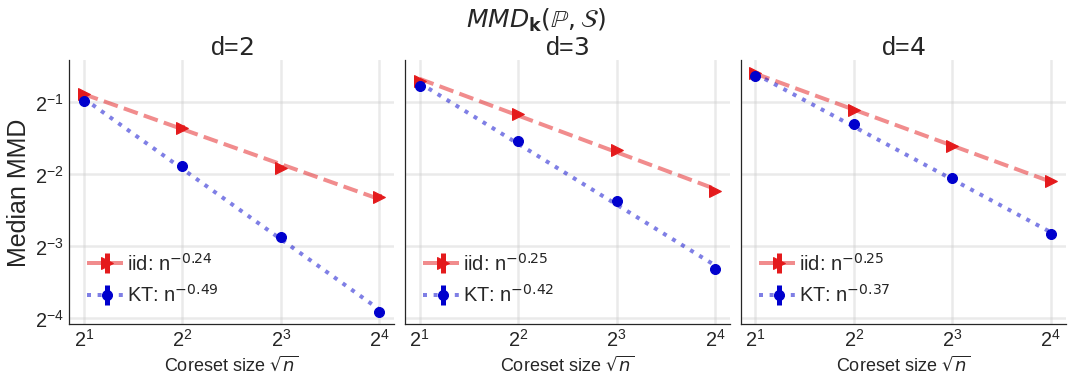

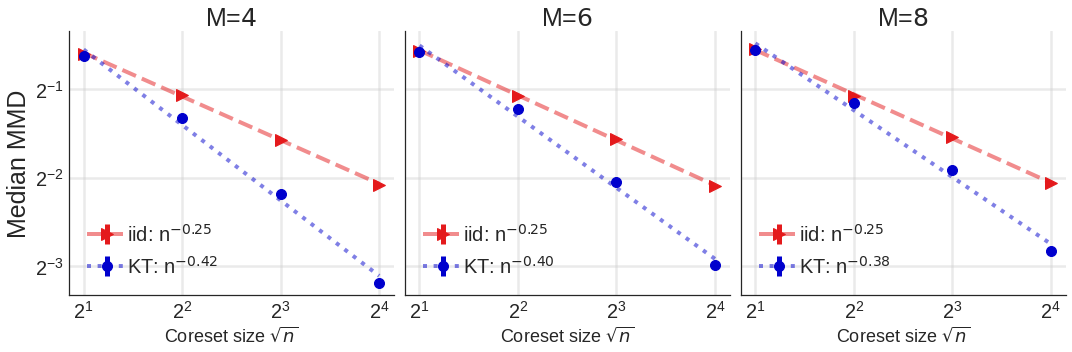

In [35]:

skip_ns = int(1)
axes = plt.subplots(1, len(ds), figsize=[5*len(ds), 5], sharex=True, sharey=True)
for i, d in enumerate(ds):
    ax = axes[1][i]
    plot_mmd_dict(ax, ms, all_mmds[f"gauss-{d}"]["P"], 0.5, skip_ns=skip_ns, error_bar=True)
    ax.set_title(r"d=$%d$"%(d), fontsize=title_size)
    if i==0:
        ax.set_ylabel(ylab, fontsize=ylab_size)
    ax.set_xlabel("Coreset size $\sqrt{n}$", fontsize=xlab_size)
plt.tight_layout()
plt.suptitle(r"$MMD_{\bf k}(\mathbb{P}, \mathcal{S})$", y=1.05, fontsize=title_size)
plt.show()

axes = plt.subplots(1, len(Ms), figsize=[5*len(ds), 5], sharex=True, sharey=True)
for i, M in enumerate(Ms):
    ax = axes[1][i]
    plot_mmd_dict(ax, ms, all_mmds[f"diagmog-{M}"]["P"], 0.5, skip_ns=skip_ns, error_bar=True)
    ax.set_title(r"M=$%d$"%(M), fontsize=title_size)
    if i==0:
        ax.set_ylabel(ylab, fontsize=ylab_size)
    ax.set_xlabel("Coreset size $\sqrt{n}$", fontsize=xlab_size)

plt.tight_layout()
plt.show()

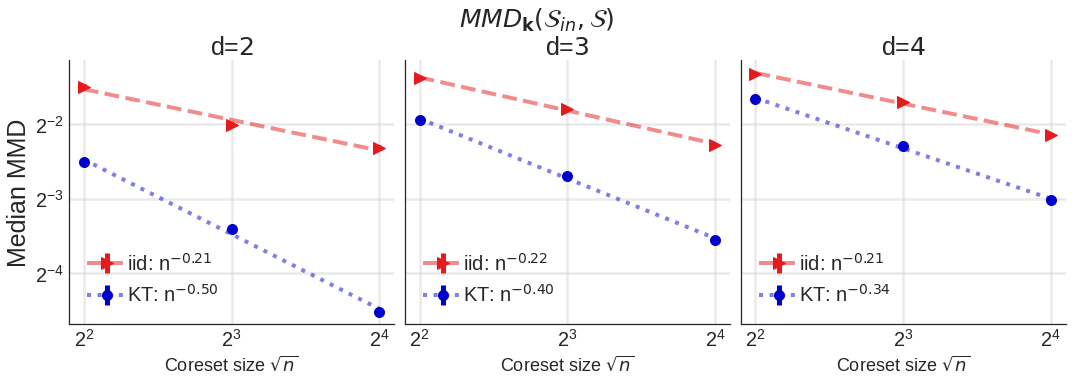

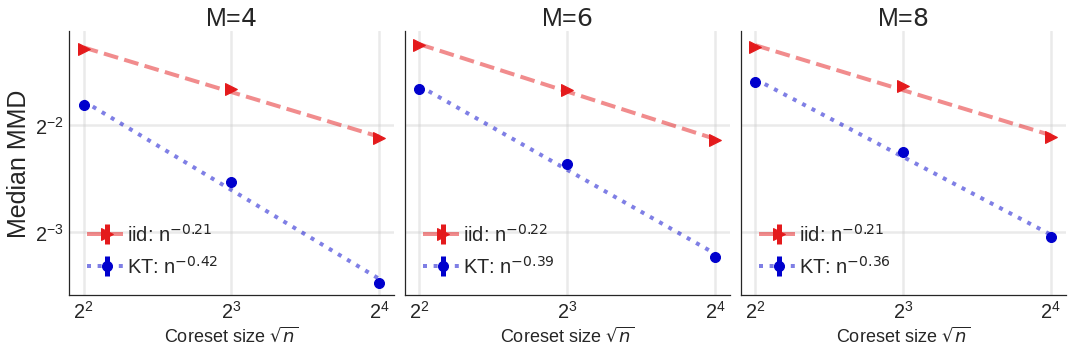

In [36]:
skip_ns = int(2)
axes = plt.subplots(1, len(ds), figsize=[5*len(ds), 5], sharex=True, sharey=True)
for i, d in enumerate(ds):
    ax = axes[1][i]
    plot_mmd_dict(ax, ms, all_mmds[f"gauss-{d}"]["Sin"], 0.5, skip_ns=skip_ns, error_bar=True)
    ax.set_title(r"d=$%d$"%(d), fontsize=title_size)
    if i==0:
        ax.set_ylabel(ylab, fontsize=ylab_size)
    ax.set_xlabel("Coreset size $\sqrt{n}$", fontsize=xlab_size)
plt.tight_layout()
plt.suptitle(r"$MMD_{\bf k}(\mathcal{S}_{in}, \mathcal{S})$", y=1.05, fontsize=title_size)
plt.show()

axes = plt.subplots(1, len(Ms), figsize=[5*len(ds), 5], sharex=True, sharey=True)
for i, M in enumerate(Ms):
    ax = axes[1][i]
    plot_mmd_dict(ax, ms, all_mmds[f"diagmog-{M}"]["Sin"], 0.5, skip_ns=skip_ns, error_bar=True)
    ax.set_title(r"M=$%d$"%(M), fontsize=title_size)
    if i==0:
        ax.set_ylabel(ylab, fontsize=ylab_size)
    ax.set_xlabel("Coreset size $\sqrt{n}$", fontsize=xlab_size)

plt.tight_layout()
plt.show()

## 2.2 MCMC MMD rates

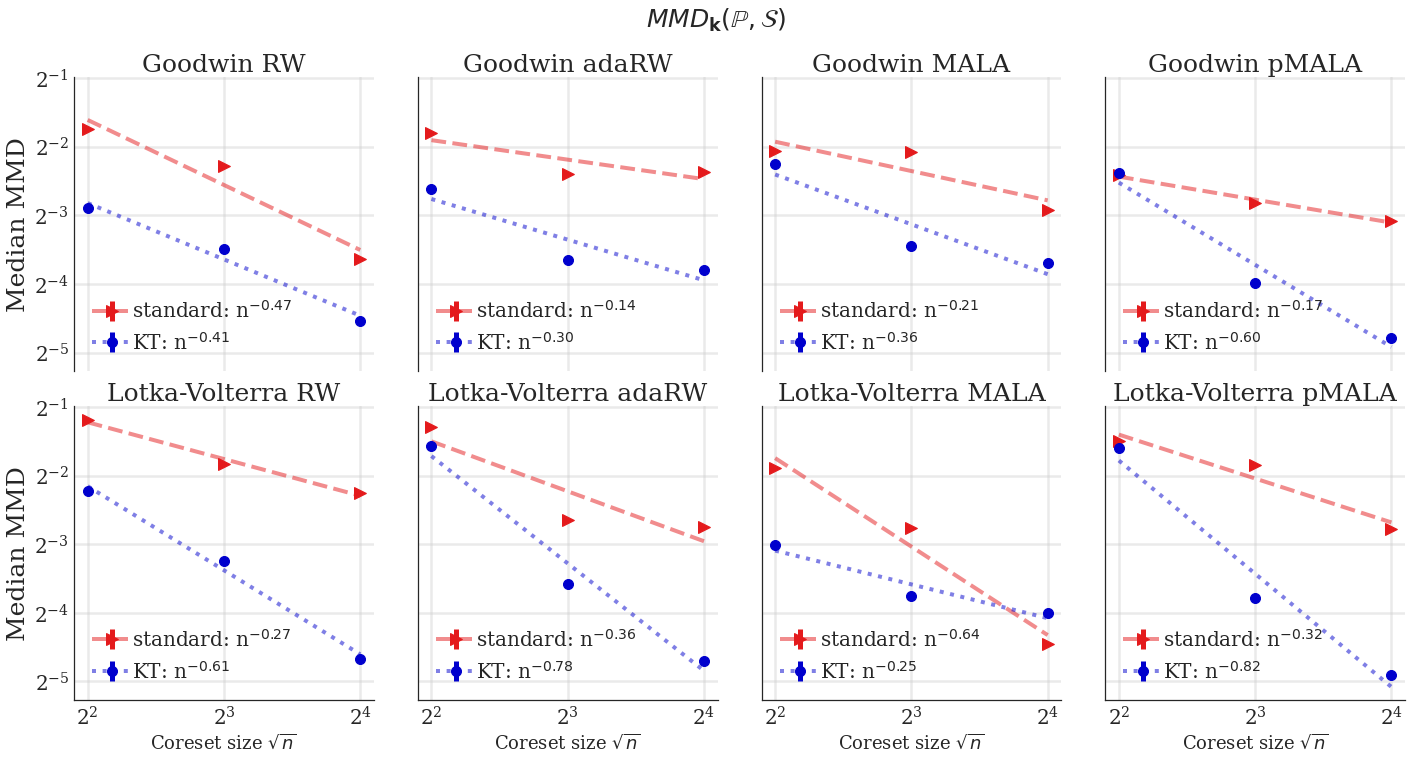

In [28]:
skip_ns = int(1)
axes = plt.subplots(2, 4, figsize=[5*4, 5*2], sharex=True, sharey=True)
axes = axes[1].flatten()
skip_ns = int(2)
for i, filename in enumerate(mcmc_adabw_file_names):
    ax = axes[i]
    plot_mmd_dict(ax, ms, mcmc_mmds[filename]["P"], 0.5, skip_ns=skip_ns, error_bar=True)
    title = filename
    if "ADA-" in filename:
        title = filename[:-6] + "adaRW"
    if "PRECOND-" in filename:
        title = filename[:-12] + "pMALA"
    title = title.replace("_", " ")
    title = title.replace("Lotka", "Lotka-Volterra")
    ax.set_title(title, fontsize=title_size)
    if i==0 or i==4:
        ax.set_ylabel(ylab, fontsize=ylab_size)
    if i>=4:
        ax.set_xlabel("Coreset size $\sqrt{n}$", fontsize=xlab_size)
    if i<4:
        ax.spines['bottom'].set_visible(False)
plt.suptitle(r"$MMD_{\bf k}(\mathbb{P}, \mathcal{S})$", y=1.05, fontsize=title_size)
plt.tight_layout()
plt.show()

In [29]:
# print(filename, np.median(mcmc_mmds[filename]["P"]["standard"], 1), np.median(mcmc_mmds[filename]["P"]["KT"], 1))

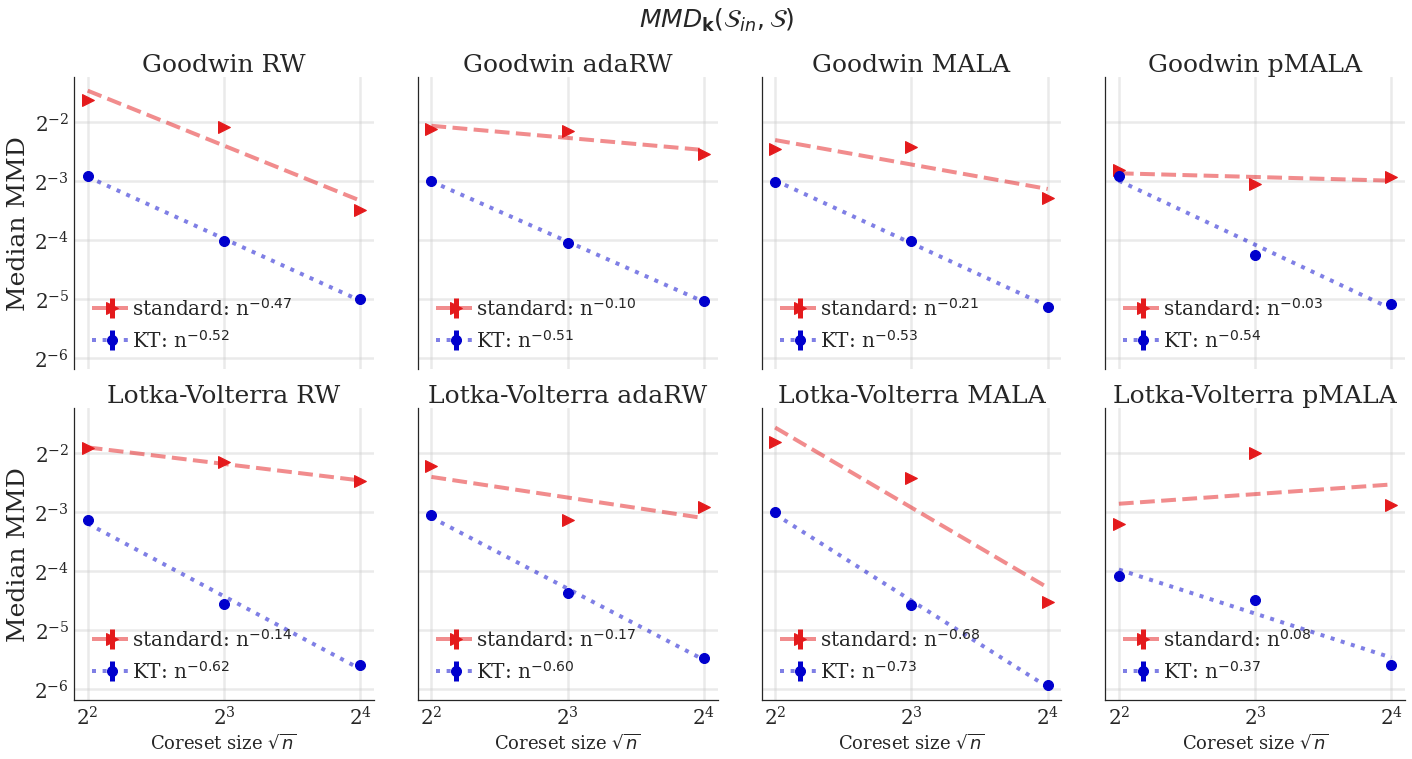

In [30]:
skip_ns = int(2)
axes = plt.subplots(2, 4, figsize=[5*4, 5*2], sharex=True, sharey=True)
axes = axes[1].flatten()
skip_ns = int(2)
for i, filename in enumerate(mcmc_adabw_file_names):
    ax = axes[i]
    plot_mmd_dict(ax, ms, mcmc_mmds[filename]["Sin"], 0.5, skip_ns=skip_ns, error_bar=True)
    title = filename
    if "ADA-" in filename:
        title = filename[:-6] + "adaRW"
    if "PRECOND-" in filename:
        title = filename[:-12] + "pMALA"
    title = title.replace("_", " ")
    title = title.replace("Lotka", "Lotka-Volterra")
    ax.set_title(title, fontsize=title_size)
    if i==0 or i==4:
        ax.set_ylabel(ylab, fontsize=ylab_size)
    if i>=4:
        ax.set_xlabel("Coreset size $\sqrt{n}$", fontsize=xlab_size)
    if i<4:
        ax.spines['bottom'].set_visible(False)
plt.suptitle(r"$MMD_{\bf k}(\mathcal{S}_{in}, \mathcal{S})$", y=1.05, fontsize=title_size)
plt.tight_layout()
plt.show()

# 3. Scatter plot of coresets for MoG

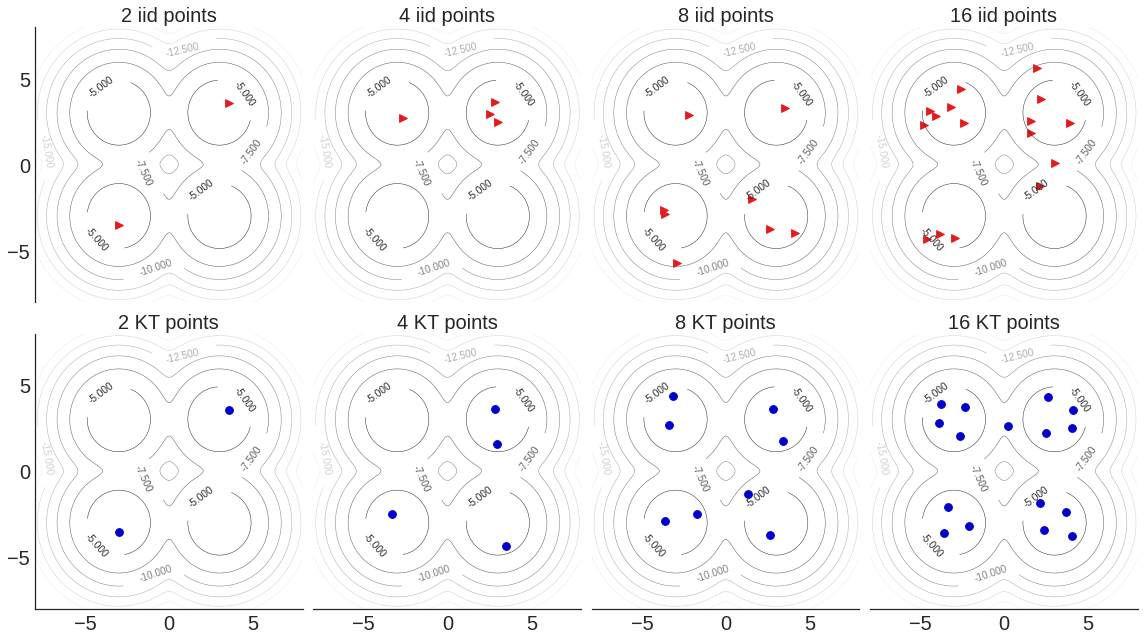

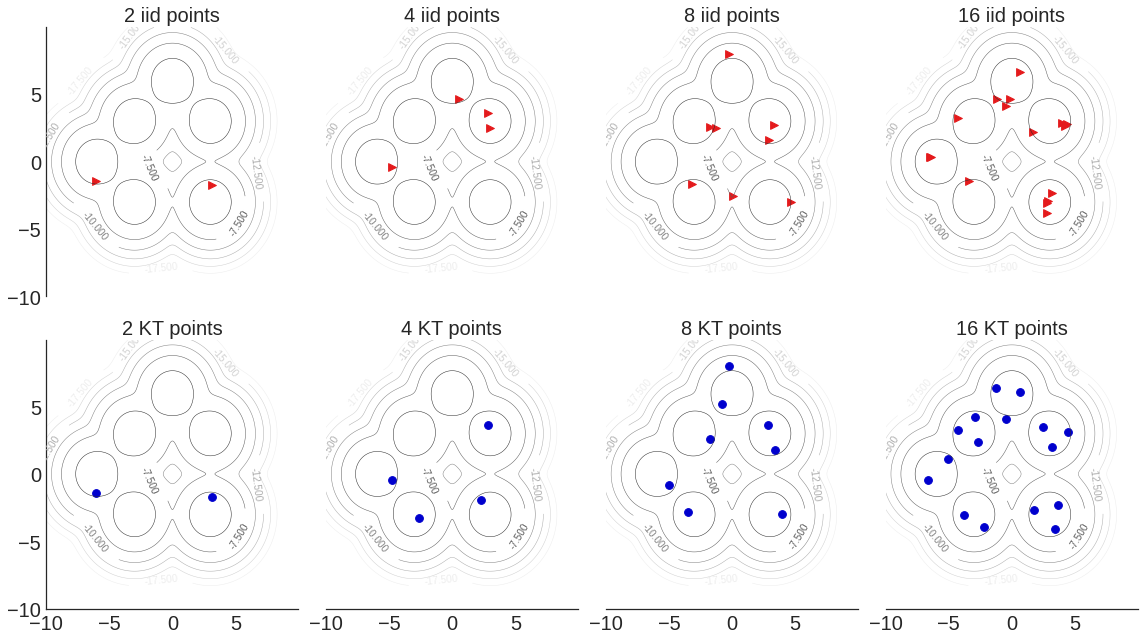

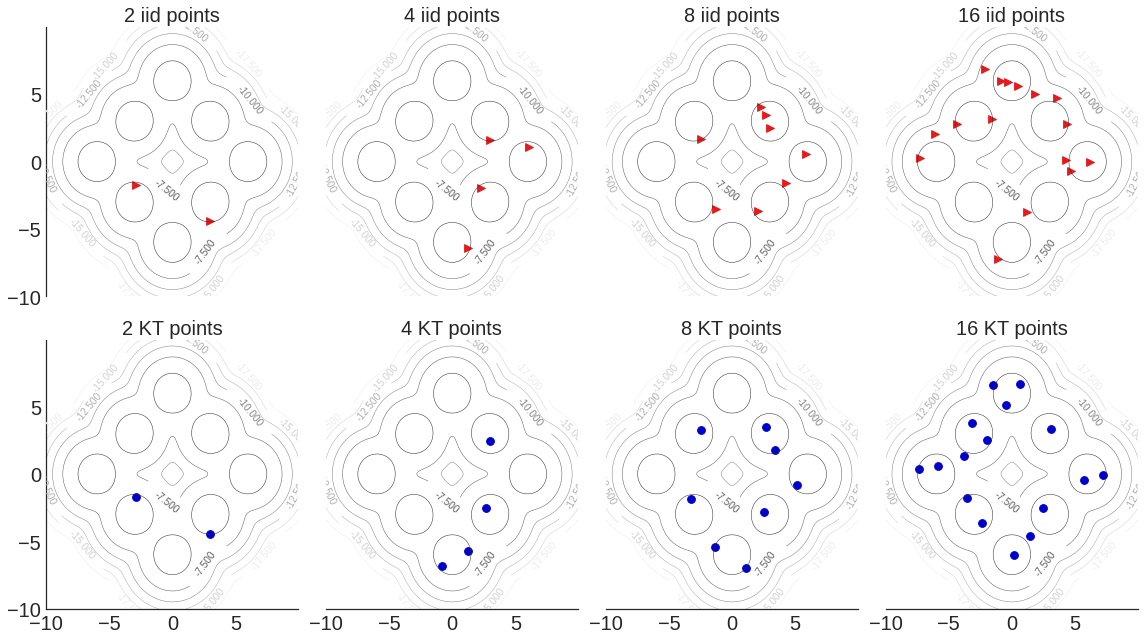

In [37]:
sample_seed = 1234567
# which rep_id's coresets to visualize
rep_id = npr.default_rng(1).choice(range(100))

# use contour (True) lines or filled contour plot (False)
contour = True

d = int(2)
var = 1.
for M in [4, 6, 8]:
    params_k_swap = {"name": "gauss", "var": var, "d": int(d)}
    params_k_split = {"name": "gauss_rt", "var": var/2., "d": int(d)}
    params_p = compute_diag_mog_params(M)
    
    # range of m to plot
    m_plot = np.arange(1, 5, dtype=int )

    # axis limits for all plots
    snr = 2*max(params_p["covs"])
    if M == 4:
        snr *= 2.5
    else:
        snr *= 2
    lim0 = np.min(params_p["means"])-snr
    lim1 = np.max(params_p["means"])+snr
    x, y = np.mgrid[lim0:lim1:.05, lim0:lim1:.05]
    pos = np.dstack((x, y))
    # compute pdf of the diag MOg density
    for i in range(M):
        rv_object = multivariate_normal(params_p["means"][i], np.eye(d) * params_p["covs"][i])
        if i == 0:
            density = params_p["weights"][i]*rv_object.pdf(pos)
        else:
            density += params_p["weights"][i]*rv_object.pdf(pos)

    axes = plt.subplots(2, len(m_plot), figsize=[4*len(m_plot), 4.5*2], sharex=True, sharey=True)    

    for i, m in enumerate(m_plot): 
        n = int(2**m)
        # load coresets
        Xs = dict()
        Xs["iid"], Xs["KT"] = load_input_and_coreset(m, params_p, params_k_split, params_k_swap, rep_id)
        for j, (label, X) in enumerate(Xs.items()):
            ax = axes[1][j][i]
            # plot density of the MoG
            if contour:
                C = ax.contour(x, y, np.log(density+np.exp(-20)), cmap="Greys", linewidths=.5)
                ax.clabel(C, inline=1, fontsize=10)
            else:
                ax.contourf(x, y, np.log(density+np.exp(-20)), cmap="Greys")
            # scatter plot
            if label == "iid":
                # do standard thinning of the iid points
                step = int(X.shape[0]/n)
                ax.scatter(X[step-1:X.shape[0]:step, 0], X[step-1:X.shape[0]:step, 1], marker=mss[j], s=60,  color=colors[j], label=label)
            else:
                ax.scatter(X[:n, 0], X[:n, 1], marker=mss[j], s=60,  color=colors[j], label=label)

            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            if label=="iid":
                ax.set_title(f"{n} iid points", fontsize=20)
            if label=="KT":
                ax.set_title(f"{n} KT points", fontsize=20)
            if i==0:
                ax.spines['left'].set_visible(True)
            if j==len(XS)-1:
                ax.spines['bottom'].set_visible(True)

    plt.tight_layout()
    plt.show()